In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab

%matplotlib inline

In [81]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    #grad_binary = np.zeros_like(gradmag)
    #grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    binary_output = gradmag
    
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

# Edit this function to create your own pipeline.
def combine_threshold(img, s_thresh=(210, 255), sx_thresh=(20, 100), r_thresh=(10,100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # RGB colour
    r_channel = img[:,:,2]
    
    # Threshold on r
    rbinary = np.zeros_like(r_channel)
    rbinary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Convert to HSV
    imgHLS = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
  
    combined = np.zeros_like(sxbinary)
    combined[(sxbinary == 1)  | (s_binary == 1) | (((rbinary == 1)) & (s_binary == 1)) ] = 1
    return combined

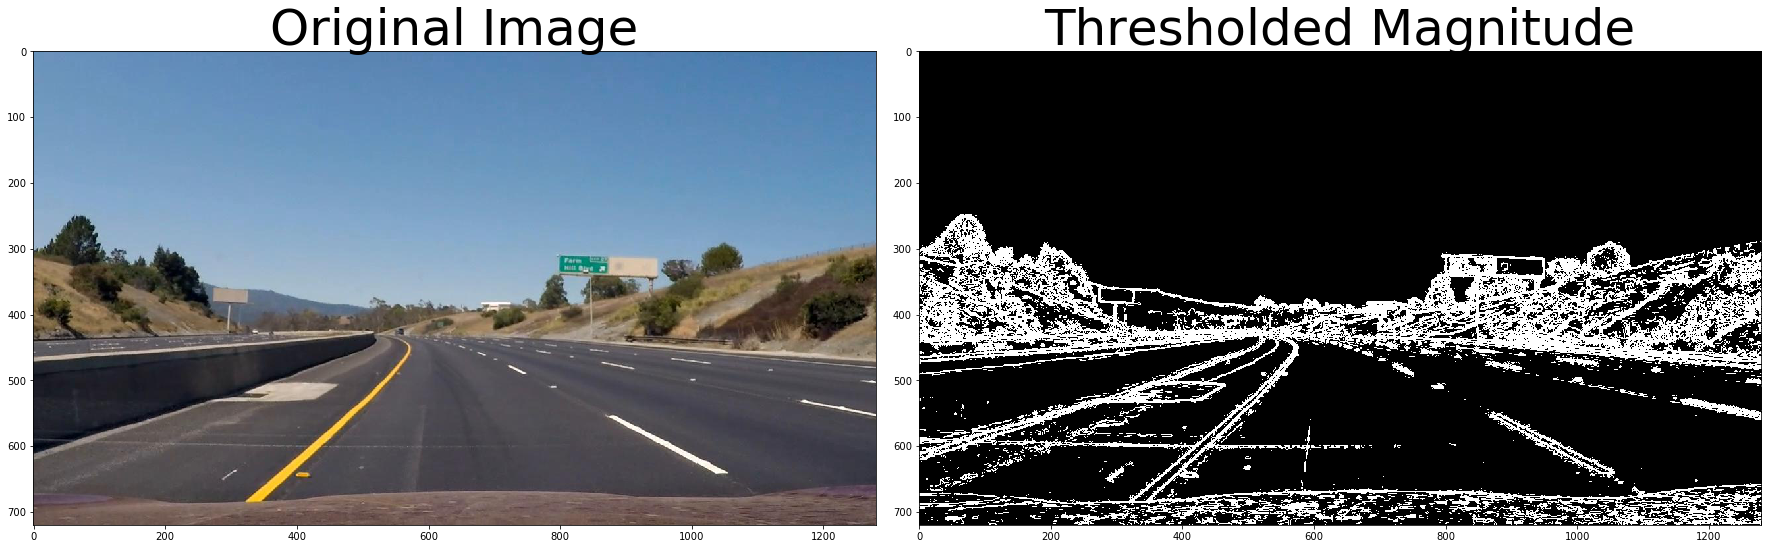

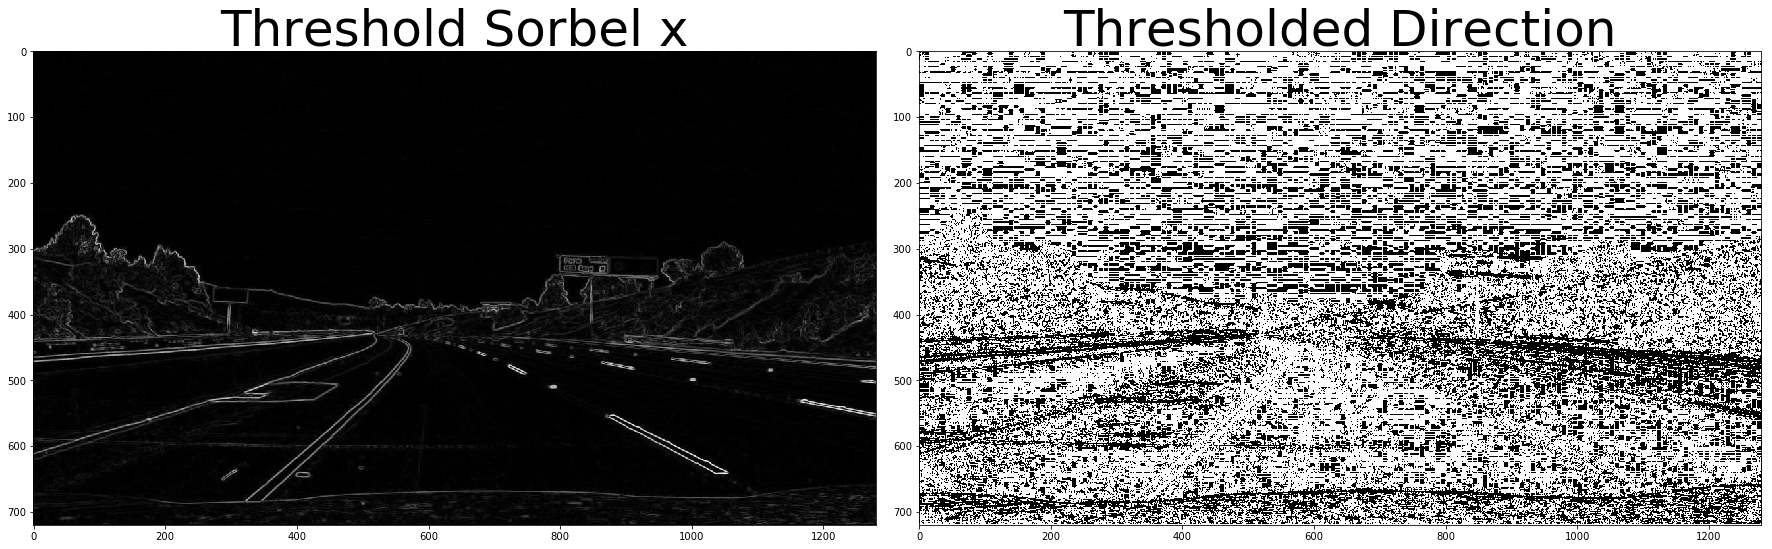

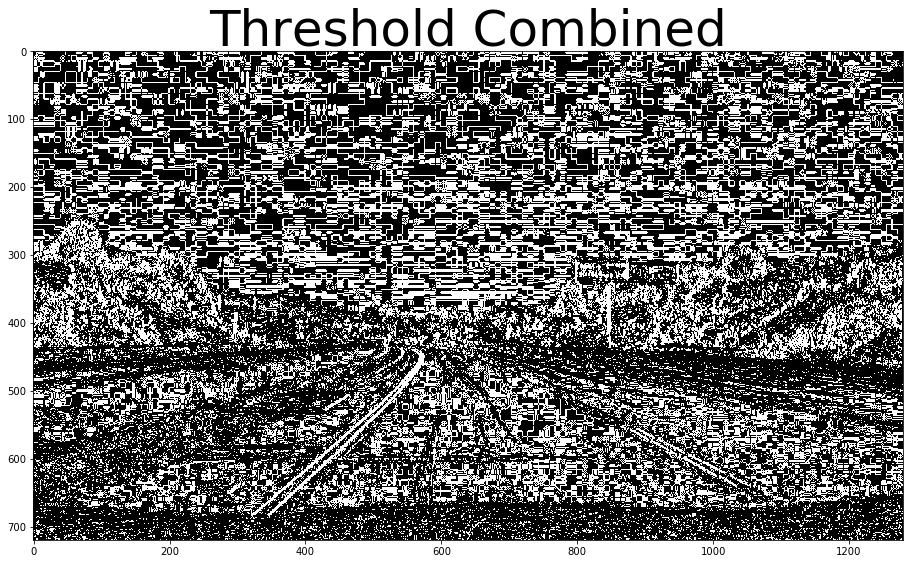

In [86]:
image = mpimg.imread('frames/0.6.jpg')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(130, 155))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(130, 155))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(10, 255))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, 1.2))

# Combine images
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
pylab.savefig('output_images/car_camera_org_mag_binary.png')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('Threshold Sorbel x', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
pylab.savefig('output_images/car_camera_sorbelx_dir_binary.png')
ax2.set_title('Thresholded Direction', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Plot combined
plt.subplots(1, 1, figsize=(24, 9))
plt.title('Threshold Combined', fontsize=50)
fig =plt.imshow(combined,cmap = 'gray')
pylab.savefig('output_images/car_camera_combined.png')

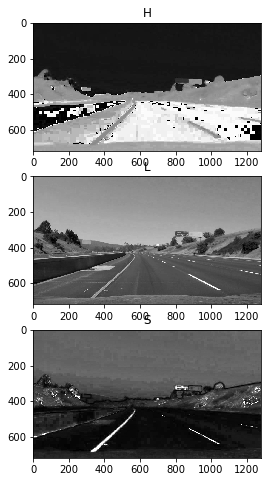

In [87]:

imgHLS = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.title('H')
fig =plt.imshow(imgHLS[:,:,0],cmap='gray')
plt.subplot(3,1,2)
plt.title('L')
fig =plt.imshow(imgHLS[:,:,1],cmap='gray')
plt.subplot(3,1,3)
plt.title('S')
fig =plt.imshow(imgHLS[:,:,2],cmap='gray')

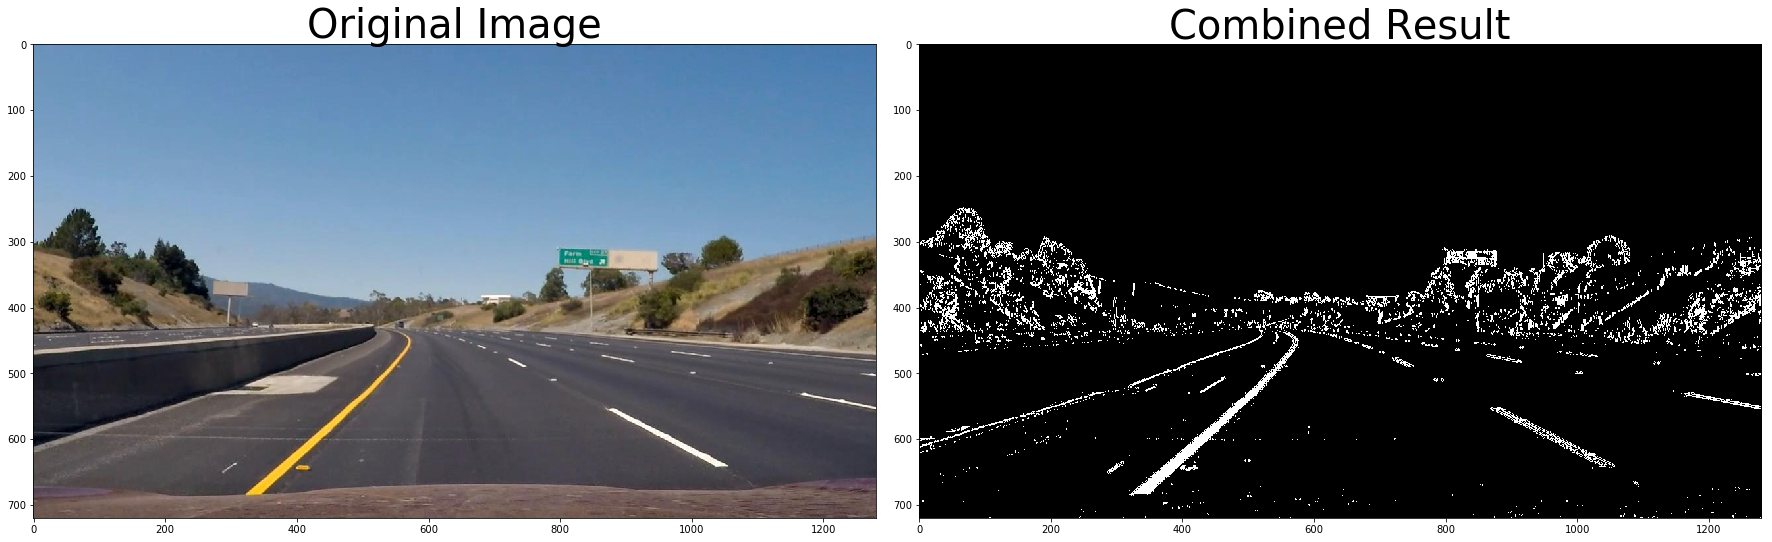

In [88]:
result = combine_threshold(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Combined Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

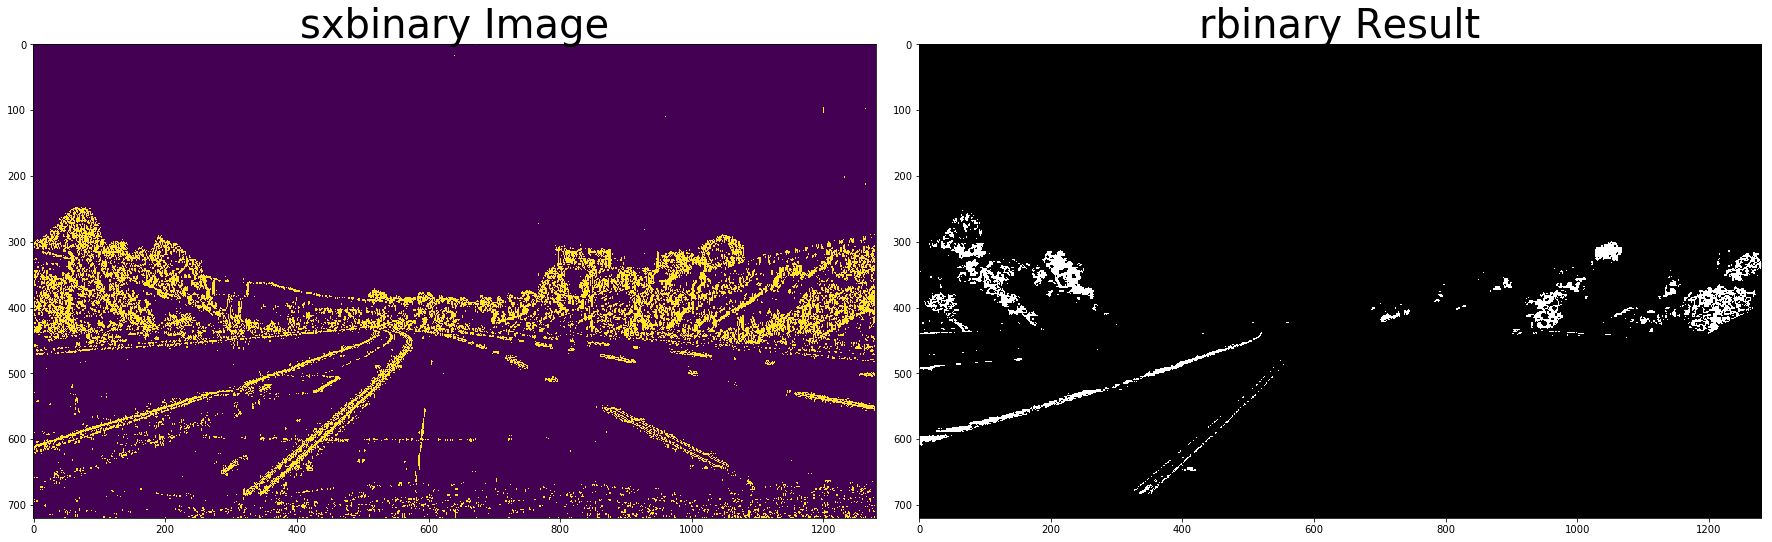

In [89]:
img = np.copy(image)
# Convert to HLS color space and separate the V channel
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hsv[:,:,1]
s_channel = hsv[:,:,2]
    
# RGB colour
r_channel = img[:,:,2]
    
# Threshold on r
rbinary = np.zeros_like(r_channel)
rbinary[(r_channel > 5) & (r_channel <= 30)] = 1
    
# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= 10) & (scaled_sobel <= 100)] = 1
    
# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= 110) & (s_channel <= 255)] = 1
    
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(sxbinary)
ax1.set_title('sxbinary Image', fontsize=40)

ax2.imshow(rbinary, cmap='gray')
ax2.set_title('rbinary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### 